# Training: Quantum case

## Preparation

We start with importing NumPy and specifying some training hyperparameters.

In [1]:
!pip install lambeq
!pip install pytket
!pip install pytket-qiskit
!pip install "discopy>=1.1.0"
!pip install qiskit-machine-learning
!pip install qiskit-aer
!pip install pennylane
!pip install pennylane-qiskit
!pip install pennylane-sf
!pip install qiskit PennyLane
!pip install qiskit_algorithms qiskit_machine_learning
!pip install qiskit-aer qiskit-ibm-runtime

  Using cached PennyLane-0.36.0-py3-none-any.whl (1.7 MB)
  Using cached PennyLane_Lightning-0.36.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.1 MB)
  Attempting uninstall: pennylane-lightning
    Found existing installation: PennyLane-Lightning 0.30.0
    Uninstalling PennyLane-Lightning-0.30.0:
      Successfully uninstalled PennyLane-Lightning-0.30.0
  Attempting uninstall: pennylane
    Found existing installation: PennyLane 0.29.1
    Uninstalling PennyLane-0.29.1:
      Successfully uninstalled PennyLane-0.29.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pennylane-sf 0.29.1 requires pennylane<0.30,>=0.19, but you have pennylane 0.36.0 which is incompatible.
  Using cached PennyLane-0.29.1-py3-none-any.whl (1.3 MB)
INFO: pip is looking at multiple versions of pennylane-lightning to determine which version is compatible with other re

In [2]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

In [3]:
import numpy as np

BATCH_SIZE = 10
EPOCHS = 180
SEED = 2

### Input data

Let's read the data and print some example sentences.

In [4]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('restaurant_v5_train.txt')
val_labels, val_data = read_data('restaurant_v5_dev.txt')
test_labels, test_data = read_data('restaurant_v5_test.txt')

In [5]:
import os

TESTING = False

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    val_labels, val_data = val_labels[:2], val_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 10

In [6]:
train_data[:5]

['I love the restaurant',
 'I dislike the restaurant',
 'I loved the great food',
 'I loved the nice food',
 'I loved the tasty food']

In [7]:
train_labels[:5]

[[1, 0], [0, 1], [1, 0], [1, 0], [1, 0]]

### Creating and parameterising diagrams

In [8]:
from lambeq import BobcatParser

parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_val_diagrams = parser.sentences2diagrams(val_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Filter and simplify diagrams

In [9]:
train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
val_diagrams = [
    diagram.normal_form()
    for diagram in raw_val_diagrams if diagram is not None
]
test_diagrams = [
    diagram.normal_form()
    for diagram in raw_test_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
val_labels = [
    label for (diagram, label)
    in zip(raw_val_diagrams, val_labels)
    if diagram is not None
]
test_labels = [
    label for (diagram, label)
    in zip(raw_test_diagrams, test_labels)
    if diagram is not None
]

Let's see the form of the diagram for a relative clause on the subject of a sentence:

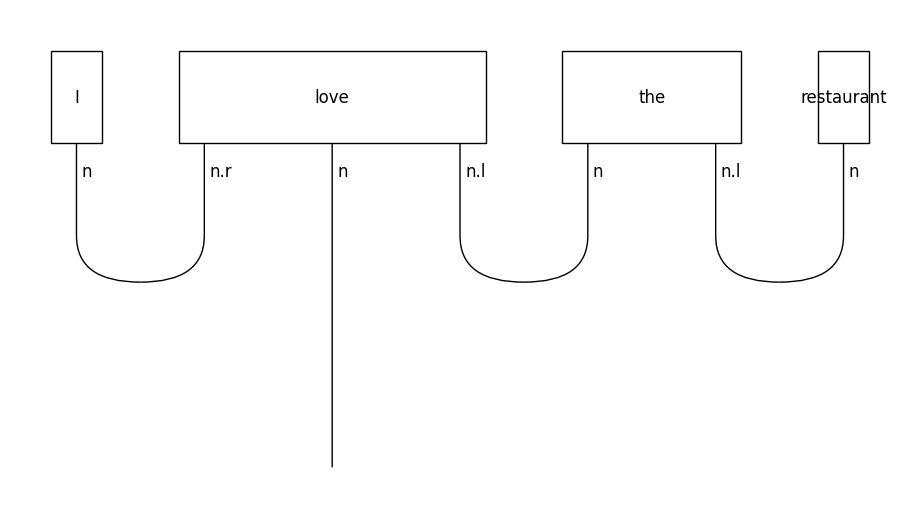

In [10]:
train_diagrams[0].draw(figsize=(9, 5), fontsize=12)

In object-based relative clauses the noun that follows the relative pronoun is the object of the sentence:

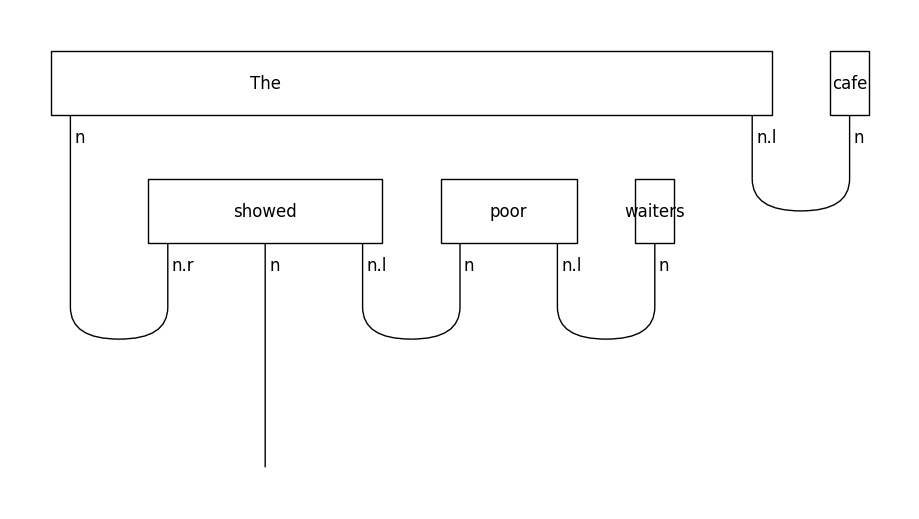

In [11]:
train_diagrams[-1].draw(figsize=(9, 5), fontsize=12)

### Create circuits

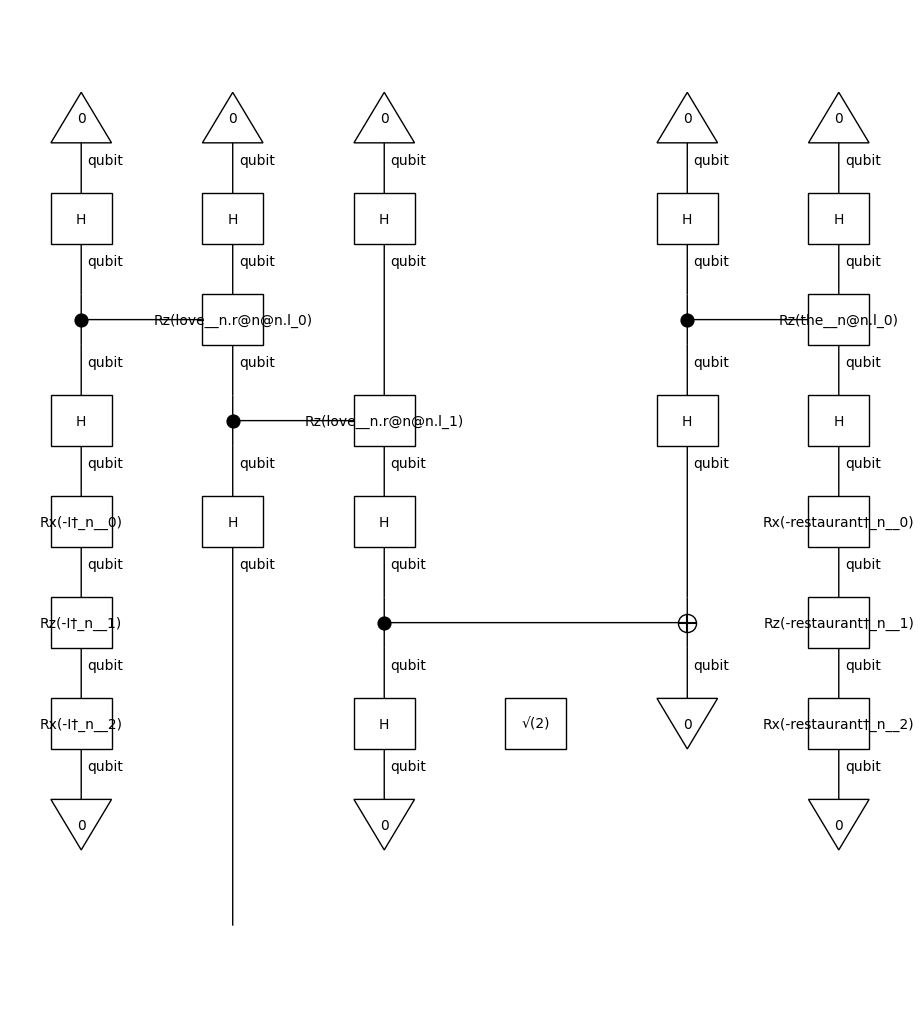

In [12]:
from lambeq import AtomicType, IQPAnsatz, RemoveCupsRewriter

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                   n_layers=1, n_single_qubit_params=3)
remove_cups = RemoveCupsRewriter()

train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
val_circuits =  [ansatz(remove_cups(diagram))  for diagram in val_diagrams]
test_circuits =  [ansatz(remove_cups(diagram))  for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 10))

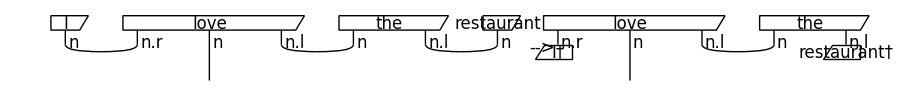

In [13]:
from lambeq.backend import draw_equation

original_diagram = train_diagrams[0]
removed_cups_diagram = remove_cups(original_diagram)

draw_equation(original_diagram, removed_cups_diagram, symbol='-->', figsize=(9, 6), asymmetry=0.3, fontsize=12)

## Training
### Instantiate the model

In [20]:
from pytket.extensions.qiskit import AerBackend, IBMQEmulatorBackend, set_ibmq_config
from lambeq import TketModel, PennyLaneModel

all_circuits = train_circuits + val_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}   # this is the default PennyLane simulator
model = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
model.initialise_weights()

### Define loss and evaluation metric

In [21]:
import torch

def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y)

### Initialise trainer

In [23]:
from lambeq import PytorchTrainer

BATCH_SIZE = 10
EPOCHS = 15
LEARNING_RATE = 0.1
SEED = 42

trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

### Create datasets

In [24]:
from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

### Train

In [25]:
trainer.fit(train_dataset, val_dataset,
            early_stopping_criterion='acc',
            early_stopping_interval=5,
            minimize_criterion=False)

Epoch 1:   train/loss: 0.0127   valid/loss: 0.1326   train/acc: 0.6842   valid/acc: 0.8125
Epoch 2:   train/loss: 0.0799   valid/loss: 0.1244   train/acc: 0.7970   valid/acc: 0.8250
Epoch 3:   train/loss: 0.0049   valid/loss: 0.0989   train/acc: 0.8553   valid/acc: 0.8625
Epoch 4:   train/loss: 0.0706   valid/loss: 0.1195   train/acc: 0.8440   valid/acc: 0.7875
Epoch 5:   train/loss: 0.0078   valid/loss: 0.0720   train/acc: 0.8534   valid/acc: 0.9125
Epoch 6:   train/loss: 0.2714   valid/loss: 0.0787   train/acc: 0.8759   valid/acc: 0.8750
Epoch 7:   train/loss: 0.0000   valid/loss: 0.0707   train/acc: 0.8778   valid/acc: 0.9000
Epoch 8:   train/loss: 0.0000   valid/loss: 0.0861   train/acc: 0.9079   valid/acc: 0.8688
Epoch 9:   train/loss: 0.0001   valid/loss: 0.1494   train/acc: 0.8271   valid/acc: 0.8187
Epoch 10:  train/loss: 0.0113   valid/loss: 0.0907   train/acc: 0.8477   valid/acc: 0.8625
Early stopping!
Best model (epoch=5, step=270) saved to
runs/Jun16_15-07-14_9da7b380d4aa/b

## Results

Finally, we visualise the results and evaluate the model on the test data.

Final test accuracy: 0.8917525773195877


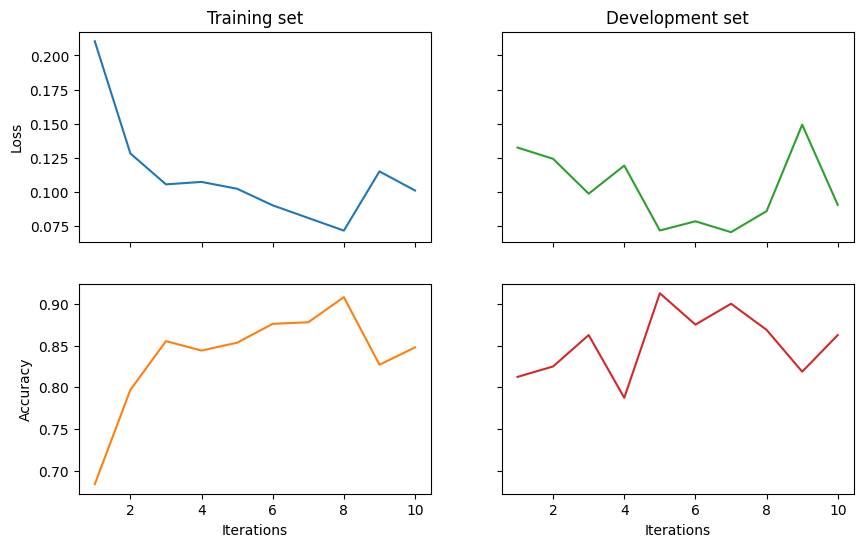

In [31]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs-4)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

In [35]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) ==
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

print('Final test accuracy: {}'.format(accuracy(test_circuits, test_labels)))


Final test accuracy: 0.8917525773195877
